# Data Science jobs Industry Classification
I am trying to create a classifier that can automatically categorize a job posting to an industry it potentially belongs to. The job posts have been collected from the reed.co.uk website using their API. In order to get access to the API I had to create an account and get a security key.
The industry labels have been assigned manually by reading each job post and making a judgement call about the sector of each job posting. Of course there is some error in this process which I will try to fix as the project progresses.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import json
import re
import os
import nltk
import processing
import pandas as pd
import json
import os
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords 
%matplotlib inline

In [32]:
os.chdir('/home/fykos/Documents/workspace/Text_Analysis/Data_Science_Jobs/')

# Load the data and join them to a new dataframe

In [33]:
reed = pd.read_json('data/raw/reed_new.json')
industries = pd.read_table('data/raw/industries.txt')

In [34]:
jobs = reed.join(industries, how = 'outer')

# Initial preparation & exploration
I am looking for the job posts that I didn't assign an industry to them, so the value is Nan. I am subsetting the dataset for the rows that don't have an assigned industry and I am creating two datasets. The dataset that has assigned industries will serve as my training dataset and the dataset without will be the test dataset.

In [35]:
# look for missing values in the Industry column
missing_industry = jobs.Industry[jobs.Industry.isnull()]

In [36]:
# subset the dataset to the indexes of the missing values and create the test dataset
test_jobs = jobs.iloc[missing_industry.index, :].reset_index()
test_jobs.drop(['Index', 'Industry', 'index'], axis = 1, inplace=True)

In [37]:
# remove the missing values from the dataset and create the training dataset
train_jobs = jobs.drop(missing_industry.index)
train_jobs.drop(['applicationCount', 'contractType', 'currency', 'datePosted', 'employerId', 
                 'expirationDate', 'jobId', 'jobUrl', 'externalUrl', 'fullTime', 'partTime', 'salaryType', 'Index'], axis = 1, inplace = True)

In [38]:
train_jobs.columns

Index([       u'employerName',      u'jobDescription',            u'jobTitle',
              u'locationName',       u'maximumSalary',       u'minimumSalary',
                    u'salary', u'yearlyMaximumSalary', u'yearlyMinimumSalary',
                  u'Industry'],
      dtype='object')

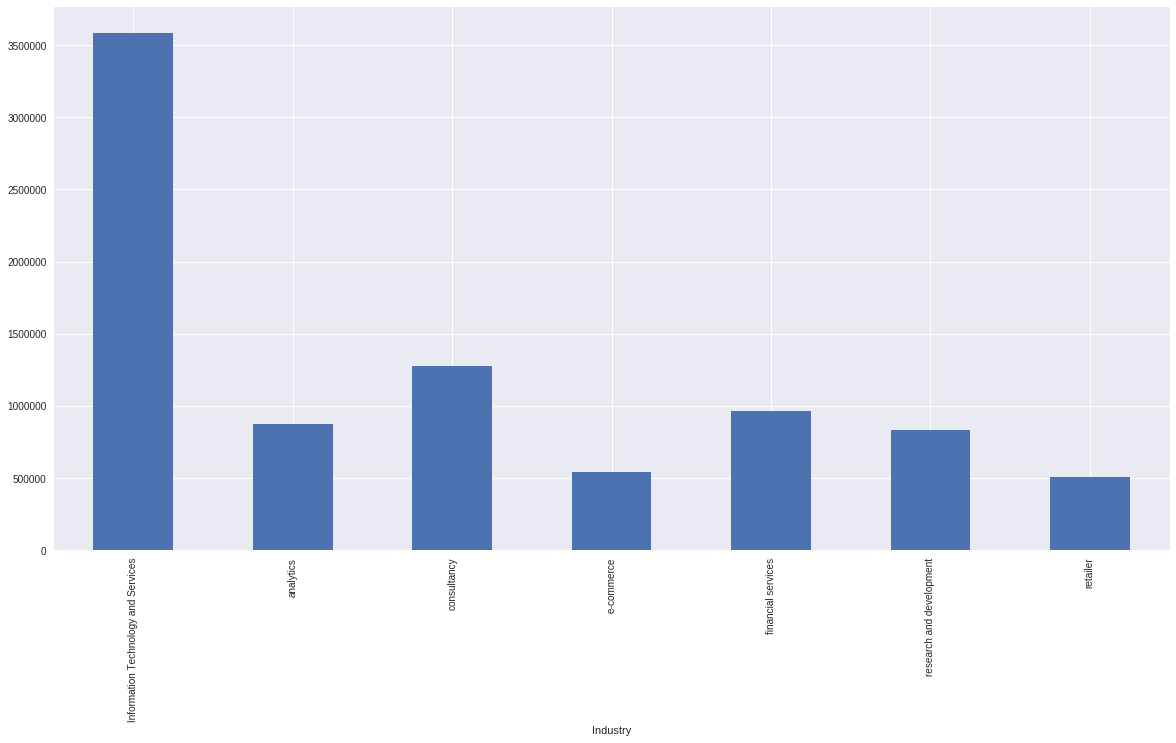

In [39]:
salaries = train_jobs.groupby(['Industry'])['yearlyMaximumSalary'].sum()
plt.figure(figsize=(20,10))
salaries.plot.bar();

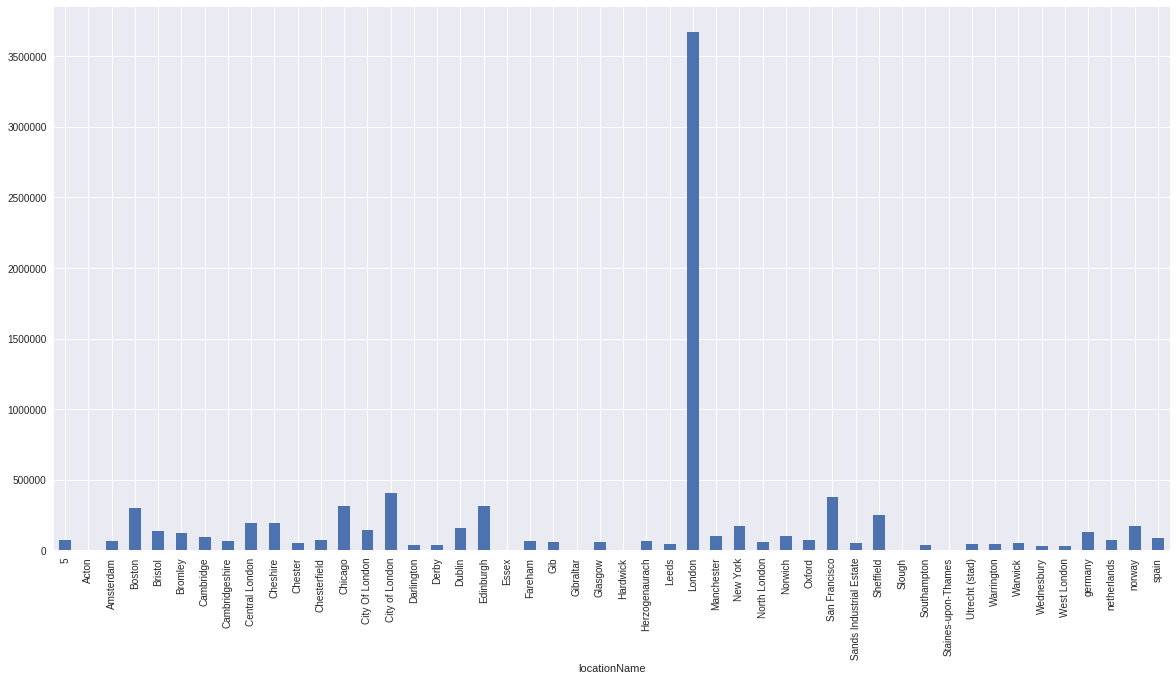

In [40]:
salaries = train_jobs.groupby(['locationName'])['yearlyMaximumSalary'].sum()
plt.figure(figsize=(20,10))
salaries.plot.bar();

In [29]:
train_jobs['jobTitle'].value_counts()

Data Scientist                                                                           38
Senior Data Scientist                                                                     7
Lead Data Scientist                                                                       6
Data Scientist                                                                            4
Junior Data Scientist                                                                     3
Chief Data Scientist                                                                      3
Data Scientist, Data Engineer, Data Analytics, Data Visualisation                         2
Graduate Data Scientist                                                                   2
Data Scientist, 6 months, London                                                          2
Data Scientist - All levels - London/Chippenham/Wales                                     1
Data Scientist / Data Pipeline Engineer Machine Learning                        

In [41]:
train_jobs['Industry'].value_counts()

Information Technology and Services    39
consultancy                            21
analytics                              17
financial services                     16
research and development               14
retailer                               10
e-commerce                             10
Name: Industry, dtype: int64

# Classification of jobs to industries

In [42]:
# convert Industry values to categorical values
train_jobs['Industry']= pd.Categorical(train_jobs['Industry'])

# convert Industry categorical values to numeric to feed in the algorithm
train_jobs['code'] = train_jobs.Industry.cat.codes

## Text processing

In [43]:
def normalize(text):
    review_text = BeautifulSoup(text, 'lxml').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = word_tokenize(letters_only.lower())
    return (' '.join(words))

In [44]:
def stemming(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in word_tokenize(text)]

In [45]:
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatizing(text):
    lmtzr = WordNetLemmatizer()
    return [lmtzr.lemmatize(word) for word in word_tokenize(text)]

In [46]:
def remove_stopwords(text):
    stops = set(stopwords.words('english'))
    for word in text:
        if word not in stops:
            return word
#     return [word for word in text if word not in stops]

In [47]:
def description_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [48]:
train_jobs.dtypes

employerName             object
jobDescription           object
jobTitle                 object
locationName             object
maximumSalary           float64
minimumSalary           float64
salary                   object
yearlyMaximumSalary     float64
yearlyMinimumSalary     float64
Industry               category
code                       int8
dtype: object

# Splitting corpus into train and test splits

In [49]:
X = train_jobs['jobDescription'] + train_jobs['jobTitle']
y = train_jobs['code']

In [50]:
from sklearn.cross_validation import train_test_split

def train(classifier, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 33)
    classifier.fit(X_train, y_train)
    
    print "Accuracy: %s" % classifier.score(X_test, y_test)
    return classifier

/home/fykos/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# First naive implementation

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
 
trial1 = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', ngram_range=(1, 3) )),
    ('classifier', LinearSVC()),
])

train(trial1, X, y)

Accuracy: 0.46875


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

# Second implementation with parameter tweaking of the TfidfVectorizer

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

trial2 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,1))),
    ('classifier', LinearSVC()),
])


train(trial2, X, y)

Accuracy: 0.4375


Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_id...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [ ]:
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

def bag_of_words(words):
    return dict([(word, True) for word in words])

def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=100):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return (words + bigrams)

descriptions = []
for description in train_jobs['jobDescription']:
    normalized = normalize(description)
    collocations = bigram_word_feats(normalized.split())
    for coloc_list in collocations:
        for item in coloc_list:
            print item
#     descriptions.append(item for item in coloc_list for coloc_list in collocations)
    
# print descriptions


# Third implementation with more text preprocessing

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

domain_keywords = ['data', 'science', 'scientist', 'machine', 'learning', 'analysis', 'analytics']

trial1 = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=domain_keywords, ngram_range=(1,3))),
    ('classifier', OneVsRestClassifier(LinearSVC())),
])

descriptions = []
for description in X:
    changed = description_to_words(description)
    descriptions.append(changed)
train(trial1, descriptions, y)

Accuracy: 0.40625


Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_id...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

# Fourth implementation adding the stemming

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

trial1 = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,3))),
    ('classifier', LinearSVC()),
])

descriptions = []
for description in train_jobs['jobDescription']:
    normalized = normalize(description)
    stems = lemmatizing(normalized)
    descriptions.append(" ".join(stems))

train(trial1, descriptions, y)

Accuracy: 0.375


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])